# NeuroDevDiff — V1.0

This notebook generates **NeuroDevDiff v1**: synthetic pediatric neurodevelopmental referral vignettes for experimenting with
AI-assisted decision support under uncertainty.

Outputs are saved under `data/` (CSV + JSONL + metadata).


In [1]:
from __future__ import annotations

import random
import pandas as pd

SEED = 42
N_CASES = 2000
NOISE_LEVEL = 1.0  # keep fixed for reproducibility

random.seed(SEED)

# --------------------------
# 1) Archetypes (neurodevelopment differential)
# --------------------------
ARCHETYPES = {
  "ASD": {
    "symptoms": {
      "social": ["reduced reciprocity", "poor peer interaction", "limited social initiation"],
      "language": ["pragmatic difficulties", "literal interpretation", "atypical prosody"],
      "rrb": ["rigid routines", "restricted interests", "repetitive behaviors"],
      "sensory": ["sensory sensitivity", "sensory seeking"]
    },
    "base_comorb": {"ADHD": 0.25, "ANXIETY": 0.20, "SLD": 0.10},
    "weights": 0.20
  },
  "ADHD": {
    "symptoms": {
      "attention": ["inattention", "disorganization", "forgetfulness"],
      "behavior": ["impulsivity", "restlessness", "interrupting others"],
      "school": ["homework incomplete", "poor sustained effort"]
    },
    "base_comorb": {"ANXIETY": 0.15, "ASD": 0.15, "SLD": 0.20},
    "weights": 0.18
  },
  "OCD": {
    "symptoms": {
      "anxiety": ["intrusive thoughts", "high distress with uncertainty"],
      "compulsions": ["checking", "washing", "counting", "reassurance seeking"],
      "avoidance": ["avoid triggers", "ritual-dependent routines"]
    },
    "base_comorb": {"ANXIETY": 0.25, "ASD": 0.10},
    "weights": 0.10
  },
  "ANXIETY": {
    "symptoms": {
      "anxiety": ["worry", "avoidance", "somatic complaints", "sleep difficulties"],
      "school": ["school refusal", "performance fear"],
      "social": ["shy/withdrawn in novel contexts"]
    },
    "base_comorb": {"ADHD": 0.10, "ASD": 0.10, "SELECTIVE_MUTISM": 0.12},
    "weights": 0.16
  },
  "SELECTIVE_MUTISM": {
    "symptoms": {
      "communication": ["speaks at home but not at school", "freezes in social settings"],
      "anxiety": ["high social inhibition", "avoidance of speaking"],
      "school": ["teacher reports silence"]
    },
    "base_comorb": {"ANXIETY": 0.35, "ASD": 0.10},
    "weights": 0.08
  },
  "SLD": {
    "symptoms": {
      "learning": ["reading difficulties", "spelling errors", "math difficulties"],
      "school": ["slow progress despite effort", "avoidance of homework"],
      "emotional": ["frustration", "low self-esteem"]
    },
    "base_comorb": {"ADHD": 0.25, "ANXIETY": 0.15},
    "weights": 0.14
  },
  "GDD_ID": {
    "symptoms": {
      "development": ["delayed milestones", "adaptive difficulties", "global learning delays"],
      "language": ["language delay", "limited vocabulary for age"],
      "motor": ["poor coordination"]
    },
    "base_comorb": {"ASD": 0.15, "ANXIETY": 0.05},
    "weights": 0.07
  },
  "NDD_UNSPEC": {
    "symptoms": {
      "mixed": ["mixed difficulties across domains", "unclear onset", "inconsistent reports"],
      "attention": ["variable attention"],
      "social": ["social withdrawal in some contexts"]
    },
    "base_comorb": {"ASD": 0.10, "ADHD": 0.10, "ANXIETY": 0.10},
    "weights": 0.07
  }
}

RED_FLAGS = [
  "self-harm thoughts",
  "acute aggression risk",
  "psychotic-like symptoms"
]

# --------------------------
# 2) Cognitive profiles (WISC/Griffith-style), scaled 1–19
# --------------------------
def _score(mean, spread=2, low=1, high=19):
    return int(min(high, max(low, random.gauss(mean, spread))))

COGNITIVE_PROFILES = {
    "ASD": {
        "verbal_language": (8, 2),
        "visuospatial": (12, 2),
        "working_memory": (7, 2),
        "processing_speed": (6, 2),
        "attention": (8, 3),
        "motor": (9, 3)
    },
    "ADHD": {
        "verbal_language": (10, 2),
        "visuospatial": (10, 2),
        "working_memory": (7, 2),
        "processing_speed": (7, 2),
        "attention": (5, 2),
        "motor": (10, 3)
    },
    "OCD": {
        "verbal_language": (12, 2),
        "visuospatial": (10, 2),
        "working_memory": (10, 2),
        "processing_speed": (8, 2),
        "attention": (10, 2),
        "motor": (10, 2)
    },
    "ANXIETY": {
        "verbal_language": (10, 2),
        "visuospatial": (10, 2),
        "working_memory": (9, 2),
        "processing_speed": (8, 2),
        "attention": (9, 2),
        "motor": (10, 2)
    },
    "SELECTIVE_MUTISM": {
        "verbal_language": (9, 2),
        "visuospatial": (10, 2),
        "working_memory": (9, 2),
        "processing_speed": (8, 2),
        "attention": (9, 2),
        "motor": (10, 2)
    },
    "SLD": {
        "verbal_language": (10, 1.5),
        "visuospatial": (10, 1.5),
        "working_memory": (10, 1.5),
        "processing_speed": (10, 1.5),
        "attention": (10, 1.5),
        "motor": (10, 1.5)
    },
    "GDD_ID": {
        "verbal_language": (4, 1),
        "visuospatial": (4, 1),
        "working_memory": (4, 1),
        "processing_speed": (4, 1),
        "attention": (4, 1),
        "motor": (4, 1)
    },
    "NDD_UNSPEC": {
        "verbal_language": (8, 3),
        "visuospatial": (8, 3),
        "working_memory": (8, 3),
        "processing_speed": (8, 3),
        "attention": (8, 3),
        "motor": (8, 3)
    }
}

def _cognitive_pattern(scores: dict) -> str:
    mx, mn = max(scores.values()), min(scores.values())
    var = mx - mn
    if var < 3 and mx <= 6:
        return "homogeneous_low"
    if var < 3:
        return "homogeneous_average"
    return "dishomogeneous"

# --------------------------
# 3) Realistic overlap + nonspecific symptoms (controlled noise)
# --------------------------
NON_SPECIFIC = [
  ("sleep", "sleep difficulties"),
  ("emotional", "irritability"),
  ("attention", "concentration problems"),
  ("emotional", "low frustration tolerance"),
]

NEIGHBORS = {
  "ASD": ["ADHD","ANXIETY","OCD"],
  "ADHD": ["ASD","ANXIETY","SLD"],
  "ANXIETY": ["OCD","SELECTIVE_MUTISM","ADHD"],
  "OCD": ["ANXIETY","ASD"],
  "SELECTIVE_MUTISM": ["ANXIETY","ASD"],
  "SLD": ["ADHD","ANXIETY"],
  "GDD_ID": ["ASD","NDD_UNSPEC"],
  "NDD_UNSPEC": ["ASD","ADHD","ANXIETY"]
}

# --------------------------
# 4) Helpers
# --------------------------
def _pick_symptoms(symptom_dict, k=4):
    all_items = []
    for dom, items in symptom_dict.items():
        all_items.extend([(dom, s) for s in items])
    picks = random.sample(all_items, k=min(k, len(all_items)))
    return picks  # list of (domain, symptom)

def _sample_comorbidity(base_comorb):
    comorbid = []
    for dx, p in base_comorb.items():
        if random.random() < p:
            comorbid.append(dx)
    return sorted(set(comorbid))

# --------------------------
# 5) Case generator
# --------------------------
def make_case(i, noise_level=1.0):
    age = random.choice([5, 6, 7, 8, 9, 10, 11, 12])
    sex = random.choice(["M", "F"])

    labels = list(ARCHETYPES.keys())
    weights = [ARCHETYPES[k]["weights"] for k in labels]
    true_dx = random.choices(labels, weights=weights, k=1)[0]
    base = ARCHETYPES[true_dx]

    severity = random.choices(["mild","moderate","severe"], weights=[0.35,0.45,0.20])[0]
    context = random.choice(["preschool", "primary school", "home+school"])
    duration = random.choice(["3 months","6 months","1 year","since early childhood"])

    core_sym = _pick_symptoms(base["symptoms"], k=4)
    comorbid = _sample_comorbidity(base["base_comorb"])

    # add nonspecific symptoms (common in clinical reality)
    if random.random() < 0.65 * noise_level:
        core_sym.append(random.choice(NON_SPECIFIC))

    # add "neighbor" symptom contamination (controlled overlap)
    if random.random() < 0.25 * noise_level:
        neigh = random.choice(NEIGHBORS[true_dx])
        core_sym.extend(_pick_symptoms(ARCHETYPES[neigh]["symptoms"], k=1))

    # if comorbidity exists, sometimes it dominates presentation
    if comorbid and random.random() < 0.15 * noise_level:
        dominant = random.choice(comorbid)
        core_sym.extend(_pick_symptoms(ARCHETYPES[dominant]["symptoms"], k=1))

    # clinical missingness (not uniform)
    onset_described = random.random() < 0.80
    cross_setting = random.random() < (0.82 if true_dx in ["ASD","ADHD","GDD_ID"] else 0.68)
    functioning_described = random.random() < (0.75 if severity != "mild" else 0.60)

    has_teacher_report = random.random() < 0.85
    has_dev_history = random.random() < 0.70
    has_language_assessment = random.random() < 0.50
    has_learning_assessment = random.random() < 0.45

    # rare risk flags (keep low; child NDD)
    risk_high = random.random() < 0.035
    red_flags = [random.choice(RED_FLAGS)] if risk_high else []

    # differential shortlist
    diff = set()
    if true_dx == "ASD": diff.update(["ADHD", "ANXIETY"])
    if true_dx == "ADHD": diff.update(["SLD", "ANXIETY", "ASD"])
    if true_dx == "SLD": diff.update(["ADHD", "ANXIETY"])
    if true_dx == "OCD": diff.update(["ANXIETY", "ASD"])
    if true_dx == "SELECTIVE_MUTISM": diff.update(["ANXIETY", "ASD"])
    if true_dx == "GDD_ID": diff.update(["ASD", "NDD_UNSPEC"])
    if true_dx == "NDD_UNSPEC": diff.update(["ASD", "ADHD", "ANXIETY"])

    diff.update(comorbid)
    diff.discard(true_dx)
    plausible_alternatives = sorted(list(diff))[:3]

    # cognitive profile
    prof = COGNITIVE_PROFILES[true_dx]
    cognitive_scores = {k: _score(mean=v[0], spread=v[1]) for k, v in prof.items()}

    # cognitive "variant" noise (keeps realism; prevents barcode learning)
    if true_dx == "ASD" and random.random() < 0.20 * noise_level:
        for k in cognitive_scores:
            cognitive_scores[k] = _score(9, 2)
    if true_dx == "ADHD" and random.random() < 0.15 * noise_level:
        for k in cognitive_scores:
            cognitive_scores[k] = _score(10, 1.5)
    if true_dx == "SLD" and random.random() < 0.10 * noise_level:
        cognitive_scores["working_memory"] = _score(8, 2)
        cognitive_scores["processing_speed"] = _score(8, 2)

    cognitive_pattern = _cognitive_pattern(cognitive_scores)

    # missing info list tailored to differential
    missing = []
    if not onset_described: missing.append("onset timeline")
    if not functioning_described: missing.append("functional impairment details")
    if not cross_setting: missing.append("cross-setting symptoms (home vs school)")
    if not has_teacher_report: missing.append("teacher report")
    if not has_dev_history: missing.append("developmental history")
    if (true_dx in ["ASD","SELECTIVE_MUTISM"] or "ASD" in plausible_alternatives) and not has_language_assessment:
        missing.append("language/pragmatics assessment")
    if (true_dx == "SLD" or "SLD" in plausible_alternatives) and not has_learning_assessment:
        missing.append("learning assessment (reading/writing/math)")

    # defer policy (tuned to avoid absurdly high defer-rate)
    critical_missing = (not onset_described) or (not functioning_described)
    high_ambiguity = (len(plausible_alternatives) >= 3) and (severity != "severe") and (len(missing) >= 2)

    if risk_high or critical_missing:
        should_defer = 1
    elif high_ambiguity:
        should_defer = 1 if random.random() < 0.60 else 0
    else:
        should_defer = 1 if random.random() < 0.15 else 0

    return {
        "case_id": i,
        "age": age,
        "sex": sex,
        "context": context,
        "duration": duration,
        "severity": severity,
        "true_profile": true_dx,
        "comorbidity": comorbid,
        "plausible_alternatives": plausible_alternatives,
        "symptoms": core_sym,   # list of (domain, symptom)
        "red_flags": red_flags,
        "missing_info_list": missing,
        "info": {
            "onset_described": onset_described,
            "cross_setting": cross_setting,
            "functioning_described": functioning_described,
            "teacher_report": has_teacher_report,
            "developmental_history": has_dev_history,
            "language_assessment": has_language_assessment,
            "learning_assessment": has_learning_assessment
        },
        "cognitive_profile": cognitive_scores,
        "cognitive_pattern": cognitive_pattern,
        "labels": {"should_defer": should_defer, "risk_high": int(risk_high)}
    }

# --------------------------
# 6) Generate dataset + dataframe (v1.0)
# --------------------------
N = N_CASES
NOISE_LEVEL = 1.0

cases = [make_case(i, noise_level=NOISE_LEVEL) for i in range(1, N+1)]

df = pd.DataFrame([{
    "case_id": c["case_id"],
    "age": c["age"],
    "sex": c["sex"],
    "context": c["context"],
    "duration": c["duration"],
    "severity": c["severity"],
    "true_profile": c["true_profile"],
    "comorbidity": ", ".join(c["comorbidity"]) if c["comorbidity"] else "",
    "plausible_alternatives": ", ".join(c["plausible_alternatives"]) if c["plausible_alternatives"] else "",
    "symptoms": "; ".join([f"{d}:{s}" for d,s in c["symptoms"]]),
    "red_flags": ", ".join(c["red_flags"]) if c["red_flags"] else "",
    "missing_info": ", ".join(c["missing_info_list"]) if c["missing_info_list"] else "",
    "should_defer": c["labels"]["should_defer"],
    "risk_high": c["labels"]["risk_high"],
    # cognitive scores
    "cog_verbal_language": c["cognitive_profile"]["verbal_language"],
    "cog_visuospatial": c["cognitive_profile"]["visuospatial"],
    "cog_working_memory": c["cognitive_profile"]["working_memory"],
    "cog_processing_speed": c["cognitive_profile"]["processing_speed"],
    "cog_attention": c["cognitive_profile"]["attention"],
    "cog_motor": c["cognitive_profile"]["motor"],
    "cognitive_pattern": c["cognitive_pattern"],
} for c in cases])

print("Dataset shape:", df.shape)
print("\nClass balance (true_profile):")
print(df["true_profile"].value_counts(normalize=True).round(3))
print("\nDefer rate:", round(df["should_defer"].mean(), 3), " | High-risk rate:", round(df["risk_high"].mean(), 3))

print("Defer rate:", df["should_defer"].mean().round(3))
print(df.groupby("true_profile")["should_defer"].mean().round(3).sort_values(ascending=False))


print(df.groupby("true_profile")[[
    "cog_verbal_language","cog_visuospatial","cog_working_memory",
    "cog_processing_speed","cog_attention","cog_motor"
]].mean().round(2))

df.head()

N = N_CASES
NOISE_LEVEL = NOISE_LEVEL


Dataset shape: (2000, 21)

Class balance (true_profile):
true_profile
ASD                 0.189
ADHD                0.180
ANXIETY             0.158
SLD                 0.142
OCD                 0.112
SELECTIVE_MUTISM    0.082
NDD_UNSPEC          0.072
GDD_ID              0.066
Name: proportion, dtype: float64

Defer rate: 0.564  | High-risk rate: 0.032
Defer rate: 0.564
true_profile
NDD_UNSPEC          0.703
ADHD                0.657
ANXIETY             0.575
ASD                 0.545
OCD                 0.529
SELECTIVE_MUTISM    0.506
SLD                 0.486
GDD_ID              0.485
Name: should_defer, dtype: float64
                  cog_verbal_language  cog_visuospatial  cog_working_memory  \
true_profile                                                                  
ADHD                             9.45              9.53                7.10   
ANXIETY                          9.32              9.39                8.52   
ASD                              7.73             10.92

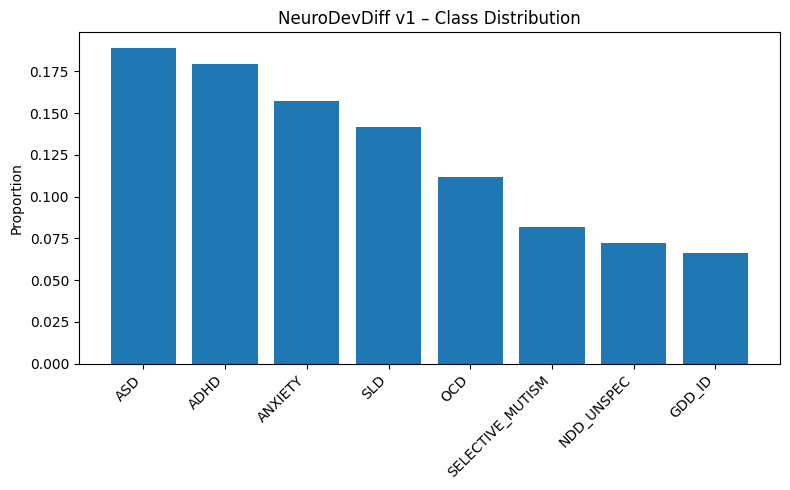

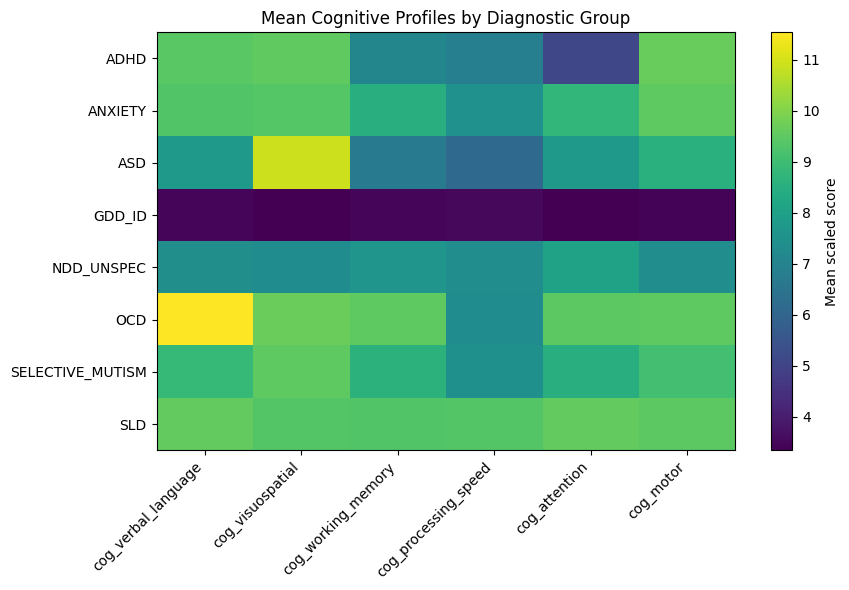

Saved figures to: /Users/galvari/Desktop/RandomJobs/NDD/NeuroDevDiff/assets


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

assets_dir = Path("../assets")
assets_dir.mkdir(exist_ok=True)

# ----------------------------
# 1) Class distribution
# ----------------------------
class_counts = df["true_profile"].value_counts(normalize=True).sort_values(ascending=False)

plt.figure(figsize=(8,5))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion")
plt.title("NeuroDevDiff v1 – Class Distribution")
plt.tight_layout()
plt.savefig(assets_dir / "class_distribution.png", dpi=200)
plt.show()
plt.close()

# ----------------------------
# 2) Cognitive profile heatmap
# ----------------------------
cog_cols = [
    "cog_verbal_language","cog_visuospatial","cog_working_memory",
    "cog_processing_speed","cog_attention","cog_motor"
]

means = df.groupby("true_profile")[cog_cols].mean()

plt.figure(figsize=(9,6))
plt.imshow(means.values, aspect="auto")
plt.colorbar(label="Mean scaled score")
plt.xticks(range(len(cog_cols)), cog_cols, rotation=45, ha="right")
plt.yticks(range(len(means.index)), means.index)
plt.title("Mean Cognitive Profiles by Diagnostic Group")
plt.tight_layout()
plt.savefig(assets_dir / "cognitive_profiles.png", dpi=200)
plt.show()
plt.close()

print("Saved figures to:", assets_dir.resolve())

## Vignette text + follow-up questions

Turn the structured fields into a short referral-style vignette and a small set of follow-up questions.


In [2]:
import random
import textwrap

SEED = 42
random.seed(SEED)

# utility: estrai sintomi per dominio dalla stringa "dom:sym; dom:sym; ..."
def parse_symptoms(symptom_str):
    items = []
    if not isinstance(symptom_str, str) or symptom_str.strip() == "":
        return items
    for part in symptom_str.split(";"):
        part = part.strip()
        if ":" in part:
            dom, sym = part.split(":", 1)
            items.append((dom.strip(), sym.strip()))
        else:
            items.append(("general", part.strip()))
    return items

def pretty_list(xs, max_items=4):
    xs = [x for x in xs if x]
    if len(xs) == 0:
        return ""
    xs = xs[:max_items]
    if len(xs) == 1:
        return xs[0]
    if len(xs) == 2:
        return f"{xs[0]} and {xs[1]}"
    return ", ".join(xs[:-1]) + f", and {xs[-1]}"

def cognitive_sentence(row):
    # converte punteggi in una frase leggibile
    vl = row["cog_verbal_language"]
    vs = row["cog_visuospatial"]
    wm = row["cog_working_memory"]
    ps = row["cog_processing_speed"]
    att = row["cog_attention"]
    mot = row["cog_motor"]
    pattern = row["cognitive_pattern"]

    # qualche descrittore semplice (evita claim clinici forti)
    def band(x):
        if x <= 4: return "markedly low"
        if x <= 7: return "below average"
        if x <= 12: return "average"
        return "above average"

    if pattern == "homogeneous_low":
        return (f"Cognitive screening suggests a globally reduced profile across domains "
                f"(verbal {band(vl)}, visuospatial {band(vs)}, working memory {band(wm)}, "
                f"processing speed {band(ps)}, attention {band(att)}, motor {band(mot)}).")
    elif pattern == "homogeneous_average":
        return (f"Cognitive screening is broadly even across domains "
                f"(verbal {band(vl)}, visuospatial {band(vs)}, working memory {band(wm)}, "
                f"processing speed {band(ps)}, attention {band(att)}, motor {band(mot)}).")
    else:
        # dishomogeneous
        # evidenzia punto di forza e debolezza
        scores = {
            "verbal/language": vl,
            "visuospatial": vs,
            "working memory": wm,
            "processing speed": ps,
            "attention": att,
            "motor": mot
        }
        strongest = max(scores, key=scores.get)
        weakest = min(scores, key=scores.get)
        return (f"Cognitive screening indicates a heterogeneous profile, with a relative strength in {strongest} "
                f"and a relative weakness in {weakest} (other domains fall in the {band( (vl+vs+wm+ps+att+mot)/6 )} range).")

# mapping “missing_info” -> domande
MISSING_TO_QUESTIONS = {
    "onset timeline": [
        "When did the difficulties first emerge, and was the onset sudden or gradual?",
        "Were there any early developmental concerns (language, play, social engagement)?"
    ],
    "functional impairment details": [
        "How do the difficulties affect daily functioning at home, school, and with peers?",
        "Which situations lead to the most impairment (transitions, homework, social demands)?"
    ],
    "cross-setting symptoms (home vs school)": [
        "Are the symptoms present across settings (home, school, community), or situation-specific?",
        "What differences do caregivers and teachers report?"
    ],
    "teacher report": [
        "Could we obtain a teacher report describing classroom behavior and learning progress?",
        "Are there standardized school observations or rating scales available?"
    ],
    "developmental history": [
        "Can we review developmental milestones (language, motor, adaptive skills) and early social communication?",
        "Any relevant perinatal/medical history?"
    ],
    "language/pragmatics assessment": [
        "Is a language and pragmatic communication assessment available (including social use of language)?",
        "Any concerns about speech production, comprehension, or narrative skills?"
    ],
    "learning assessment (reading/writing/math)": [
        "Have reading, writing, and math skills been formally assessed (psychoeducational testing)?",
        "What was the response to targeted school interventions?"
    ]
}

# prompt scaffolding: variability linguistica minima per non fare template troppo rigido
OPENERS = [
    "A child is referred for evaluation due to concerns about functioning in everyday contexts.",
    "A pediatric neurodevelopmental evaluation is requested based on caregiver and school concerns.",
    "This case describes a child presenting with developmental and behavioral concerns."
]
CONTEXT_SENT = {
    "preschool": [
        "The child is currently attending preschool.",
        "The child is in a preschool setting."
    ],
    "primary school": [
        "The child is currently attending primary school.",
        "The child is in a primary school setting."
    ],
    "home+school": [
        "Concerns are reported across both home and school contexts.",
        "Difficulties are described in multiple settings, including home and school."
    ]
}
SEVERITY_SENT = {
    "mild": [
        "Overall severity is described as mild, though specific situations can be challenging.",
        "Difficulties are mild overall, with noticeable impact in select contexts."
    ],
    "moderate": [
        "Overall severity is described as moderate, with meaningful impact on daily routines.",
        "Difficulties are of moderate severity and interfere with daily functioning."
    ],
    "severe": [
        "Overall severity is described as severe, with substantial functional impact.",
        "Difficulties are severe and significantly disrupt daily functioning."
    ]
}

def build_vignette(row):
    age = int(row["age"])
    sex = row["sex"]
    context = row["context"]
    duration = row["duration"]
    severity = row["severity"]

    sym_items = parse_symptoms(row["symptoms"])
    # scegli 4-6 sintomi da citare
    random.shuffle(sym_items)
    sym_items = sym_items[:min(len(sym_items), random.choice([4,5,6]))]
    sym_phrases = [s for d,s in sym_items]
    symptoms_text = pretty_list(sym_phrases, max_items=6)

    # red flags: menzionali senza dettagli sensazionalistici
    red = row["red_flags"]
    red_text = ""
    if isinstance(red, str) and red.strip():
        red_text = " A safety screen notes a potential red-flag item that warrants clinical attention."

    cog_text = cognitive_sentence(row)

    missing = row["missing_info"] if isinstance(row["missing_info"], str) else ""
    missing_list = [m.strip() for m in missing.split(",") if m.strip()]
    if len(missing_list) > 0:
        missing_note = f" Key information is currently missing (e.g., {pretty_list(missing_list, max_items=3)}), which increases uncertainty."
    else:
        missing_note = " Available information is reasonably complete, though further clarification may still be helpful."

    opener = random.choice(OPENERS)
    ctx_sent = random.choice(CONTEXT_SENT.get(context, ["The child is currently in school."]))
    sev_sent = random.choice(SEVERITY_SENT.get(severity, ["Severity is variable."]))

    vignette = (
        f"{opener} "
        f"The patient is a {age}-year-old {('boy' if sex=='M' else 'girl')}. {ctx_sent} "
        f"Reported concerns have been present for {duration}. {sev_sent} "
        f"Core features include {symptoms_text}.{red_text}\n\n"
        f"{cog_text}\n\n"
        f"{missing_note}"
    )

    # wrap leggero (opzionale)
    return textwrap.fill(vignette, width=110)

def build_questions(row, max_q=5):
    missing = row["missing_info"] if isinstance(row["missing_info"], str) else ""
    missing_list = [m.strip() for m in missing.split(",") if m.strip()]
    qs = []
    for m in missing_list:
        qs.extend(MISSING_TO_QUESTIONS.get(m, []))
    # se poche info mancanti, aggiungi domande “generiche” sensate
    if len(qs) < 2:
        qs.extend([
            "What are the child's strengths and which situations are most successful?",
            "Are there any prior assessments or interventions, and what was the response?"
        ])
    # dedup + sample
    seen = set()
    qs2 = []
    for q in qs:
        if q not in seen:
            seen.add(q)
            qs2.append(q)
    random.shuffle(qs2)
    return qs2[:max_q]

# Aggiungi colonne testuali
df = df.copy()
df["vignette_en"] = df.apply(build_vignette, axis=1)
df["questions_to_ask_en"] = df.apply(lambda r: build_questions(r, max_q=5), axis=1)

# (opzionale) rationale breve per should_defer, utile per LLM supervision
def build_rationale(row):
    if int(row["risk_high"]) == 1:
        return "Defer: a red-flag item requires clinician-led risk assessment."
    missing = row["missing_info"] if isinstance(row["missing_info"], str) else ""
    if int(row["should_defer"]) == 1:
        if missing.strip():
            return f"Defer: missing key information ({missing}) increases diagnostic uncertainty."
        return "Defer: uncertainty is high; additional clinical information is needed before decisions."
    return "No defer: available information supports a tentative working hypothesis, with routine follow-up questions."

df["should_defer_rationale_en"] = df.apply(build_rationale, axis=1)

df[["true_profile","should_defer","vignette_en","questions_to_ask_en"]].head(3)


,true_profile,should_defer,vignette_en,questions_to_ask_en
0,SLD,0,A child is referred for evaluation due to conc...,"[Have reading, writing, and math skills been f..."
1,ANXIETY,1,A child is referred for evaluation due to conc...,"[When did the difficulties first emerge, and w..."
2,SELECTIVE_MUTISM,0,This case describes a child presenting with de...,"[Any concerns about speech production, compreh..."


## Train/val/test split + export

Create stratified splits and write outputs to `data/`.


In [11]:
from pathlib import Path
from datetime import datetime, timezone
from sklearn.model_selection import train_test_split
import json

# -----------------------------
# Paths
# -----------------------------
DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Train / Val / Test split
# -----------------------------
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=SEED,
    stratify=df["true_profile"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=SEED,
    stratify=temp_df["true_profile"]
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

# -----------------------------
# Save CSV
# -----------------------------
df.to_csv(DATA_DIR / "neurodevdiff_v1_full.csv", index=False)
train_df.to_csv(DATA_DIR / "neurodevdiff_v1_train.csv", index=False)
val_df.to_csv(DATA_DIR / "neurodevdiff_v1_val.csv", index=False)
test_df.to_csv(DATA_DIR / "neurodevdiff_v1_test.csv", index=False)

# -----------------------------
# JSONL (LLM-friendly)
# -----------------------------
def to_jsonl(df_part, path):
    with open(path, "w", encoding="utf-8") as f:
        for _, r in df_part.iterrows():
            record = {
                "input": r["vignette_en"],
                "output": {
                    "should_defer": int(r["should_defer"]),
                    "rationale": r["should_defer_rationale_en"],
                    "questions_to_ask": r["questions_to_ask_en"],
                    "differential_hypotheses": (
                        [r["true_profile"]] +
                        [x.strip() for x in str(r["plausible_alternatives"]).split(",") if x.strip()][:2]
                    )
                },
                "meta": {
                    "true_profile": r["true_profile"],
                    "risk_high": int(r["risk_high"]),
                    "severity": r["severity"],
                    "age": int(r["age"]),
                    "sex": r["sex"]
                }
            }
            f.write(json.dumps(record, ensure_ascii=False) + "\n")

to_jsonl(train_df, DATA_DIR / "neurodevdiff_v1_train.jsonl")
to_jsonl(val_df,   DATA_DIR / "neurodevdiff_v1_val.jsonl")
to_jsonl(test_df,  DATA_DIR / "neurodevdiff_v1_test.jsonl")

# -----------------------------
# Metadata
# -----------------------------
meta = {
    "dataset": "NeuroDevDiff",
    "version": "1",
    "n_cases": int(len(df)),
    "seed": int(SEED),
    "noise_level": float(NOISE_LEVEL),
    "class_balance": df["true_profile"].value_counts(normalize=True).round(4).to_dict(),
    "defer_rate": float(df["should_defer"].mean()),
    "risk_high_rate": float(df["risk_high"].mean()),
    "created_utc": datetime.now(timezone.utc).isoformat(timespec="seconds"),
}

with open(DATA_DIR / "neurodevdiff_v1_metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("Saved dataset to:", DATA_DIR.resolve())

Train: (1400, 24) Val: (300, 24) Test: (300, 24)
Saved dataset to: /Users/galvari/Desktop/RandomJobs/NDD/NeuroDevDiff/data
